## Final Project Submission

Please fill out:
* Student name: Abdulrahman Aber, Benjamin Bai, Charles Pan, Kevin Rivera
* Student pace: Full Time
* Scheduled project review date/time: 
* Instructor name: David Elliott
* Blog post URL:


# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3 as sq
conn = sq.connect('./zippedData/im.db/im.db')
cur = conn.cursor()

# Load all source files as dataframes

In [2]:
bom_movie_gross_df = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')

In [3]:
movie_basics_df = pd.read_sql('''select * from movie_basics''', conn)

In [4]:
directors_df = pd.read_sql("""select * from directors""",conn)

In [5]:
known_for_df = pd.read_sql("""select * from known_for""",conn)

In [6]:
movie_akas_df = pd.read_sql("""select * from movie_akas""",conn)

In [7]:
movie_ratings_df = pd.read_sql("""select * from movie_ratings""",conn)

In [8]:
persons_df = pd.read_sql("""select * from persons""",conn)

In [9]:
principals_df = pd.read_sql("""select * from principals""",conn)

In [10]:
writers_df = pd.read_sql("""select * from writers""",conn)

In [11]:
rt_movie_info_df = pd.read_csv('./zippedData/rt.movie_info.tsv.gz', sep='\t')

In [12]:
rt_reviews_df = pd.read_csv('./zippedData/rt.reviews.tsv.gz', sep='\t', encoding= 'unicode_escape')

In [13]:
tmdb_movies_df = pd.read_csv('./zippedData/tmdb.movies.csv.gz')

In [14]:
tn_movie_budgets_df = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz',
                                 parse_dates=['release_date'])

# TN Movie Budgets Clean Up Process

In [15]:
# Remove $ from production_budget, convert to float
tn_movie_budgets_df['production_budget'] = tn_movie_budgets_df['production_budget'].str.replace(',', '').str.replace('$', '').astype(float)

# Remove $ from domestic_gross, convert to float
tn_movie_budgets_df['domestic_gross'] = tn_movie_budgets_df['domestic_gross'].str.replace(',', '').str.replace('$', '').astype(float)

# Remove $ from worldwide_gross, convert to float
tn_movie_budgets_df['worldwide_gross'] = tn_movie_budgets_df['worldwide_gross'].str.replace(',', '').str.replace('$', '').astype(float)

# new column release_year from release_date to filter based on time frame in scope
tn_movie_budgets_df['release_year'] = pd.DatetimeIndex(tn_movie_budgets_df['release_date']).year

# time frame: 2010-Present; SAG definition of theatrical: budget > 2 million
tn_movie_budgets_df = tn_movie_budgets_df[(tn_movie_budgets_df.release_year >= 2010) & (tn_movie_budgets_df.production_budget > 1999999)]

# Merge TN Movie Budgets with IMDB Movie Basics for Genres Analysis

In [16]:
# rename movie_basics column to match tn_movie_budgets
movie_basics_df.rename(columns={"primary_title":"movie"}, inplace = True)

# merge movie_budgets and imdb movie_basics
moviebudgets_moviebasics_df = tn_movie_budgets_df.merge(movie_basics_df, how='inner', on='movie')

# drop columns that are not relevant to Genre analysis
moviebudgets_moviebasics_df.drop(columns = ['id','release_date', 'movie_id', 'original_title', 'runtime_minutes', 'domestic_gross' ],axis=1,inplace=True)

# remove duplicate movies
moviebudgets_moviebasics_df.drop_duplicates(subset='movie', keep='first', inplace=True, ignore_index=False)

# add column for net_return
moviebudgets_moviebasics_df['net_return'] = (moviebudgets_moviebasics_df['worldwide_gross'] - moviebudgets_moviebasics_df['production_budget'])

# add column for ROI as a %
moviebudgets_moviebasics_df['roi_percent'] = ((moviebudgets_moviebasics_df['net_return'] / moviebudgets_moviebasics_df['production_budget'])*100)

# Genres Analysis Visualizations

In [67]:
# genres to list 
moviebudgets_moviebasics_df['genres'] = moviebudgets_moviebasics_df['genres'].str.split(",")
# explode out rows for movies with multiple genres for visualization purposes
moviebudgets_moviebasics_df = moviebudgets_moviebasics_df.explode('genres')
# means grouped by genre
moviebudgets_moviebasics_mean_df = moviebudgets_moviebasics_df.groupby(['genres']).mean().reset_index()

Text(0, 0.5, 'Net Return (Hundreds of Millions)')

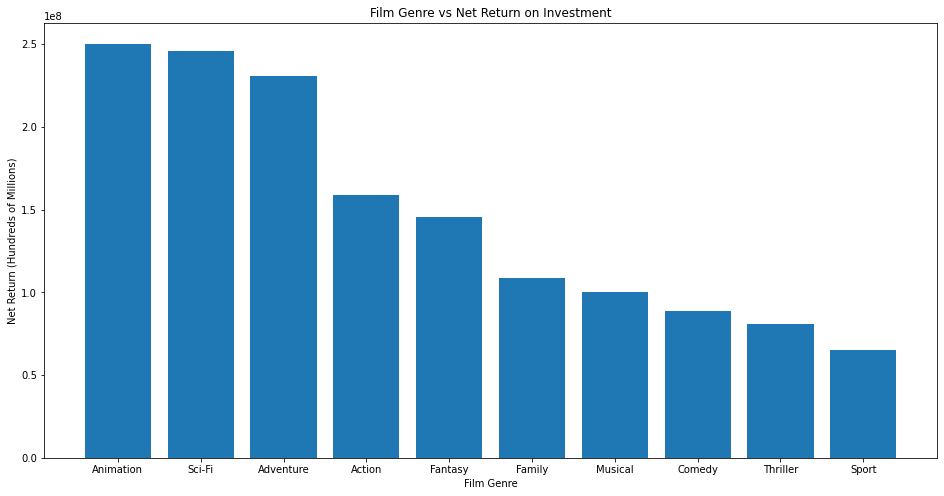

In [79]:
# visualization 1: net return
net_return_vis = moviebudgets_moviebasics_mean_df.sort_values(by='net_return', ascending=False).head(10)


fig, ax = plt.subplots(figsize=(16, 8))
x_values = list(net_return_vis['genres'])
y_values = list(net_return_vis['net_return'])

ax.bar(x_values, y_values)
ax.set_title('Film Genre vs Net Return on Investment')
plt.xlabel('Film Genre')
plt.ylabel('Net Return (Hundreds of Millions)')


Text(0, 0.5, 'ROI %')

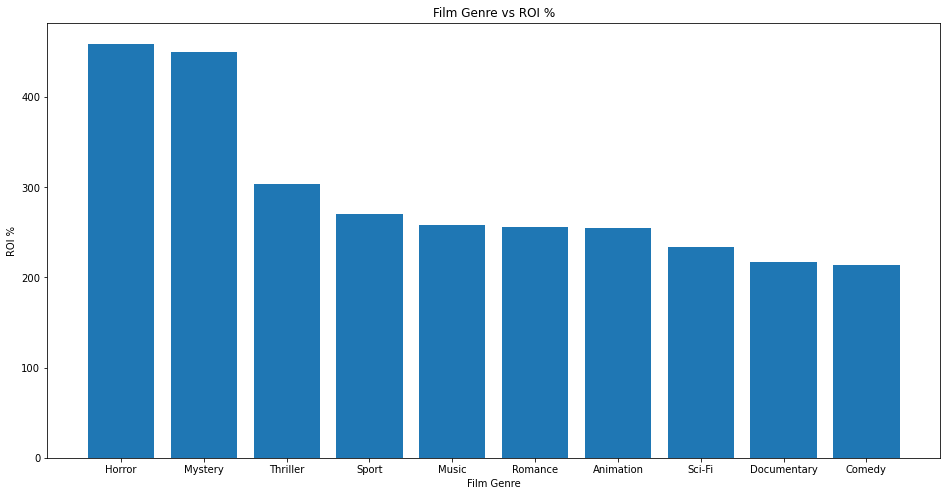

In [78]:
# visualization 1: net return
roi_vis = moviebudgets_moviebasics_mean_df.sort_values(by='roi_percent', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(16, 8))
x_values = list(roi_vis['genres'])
y_values = list(roi_vis['roi_percent'])

ax.bar(x_values, y_values)
ax.set_title('Film Genre vs ROI %')
plt.xlabel('Film Genre')
plt.ylabel('ROI %')